# Lab 14: Conditional Probability

# 0. Intro
Welcome to Lab 14!

Today's lab will review [conditional probability from the textbook](http://www.inferentialthinking.com/chapter6/conditional.html) (which is explored in more depth in these [example](http://nbviewer.jupyter.org/url/norvig.com/ipython/Probability.ipynb) [notebooks](http://nbviewer.jupyter.org/url/norvig.com/ipython/ProbabilityParadox.ipynb) for those who are interested). Probability is a different way of thinking about prediction, and an important topic in its own right.

#### Administrative details
Lab submissions are due by **Friday, April 29 at 7:00 PM**.

As usual, if you attend lab section and make a good effort but don't finish during the 2 hours, let your TA know, and you'll get full credit for the lab.

In [1]:
# Run this cell, but please don't change it.

# These lines import the Numpy and Datascience modules.
import numpy as np
from datascience import *

# These lines do some fancy plotting magic.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

# This line loads the visualization code for this lab.
import visualizations

# These lines load the tests.
from client.api.assignment import load_assignment 
lab14 = load_assignment('lab14.ok')

Assignment: Lab 14
OK, version v1.5.1



# 1. What is conditional probability good for?

Suppose we have a known population, like all dogs in California.  So far, we've seen 3 ways of *predicting* something about an individual in that population, given incomplete knowledge about the identity of the individual:

* If we know nothing about the individual dog, we could predict that its speed is the *average* or *median* of all the speeds in the population.
* If we know the dog's height but not its speed, we could use *linear regression* to predict its speed from its height.  The resulting prediction is still imperfect, but it might be more accurate than the population average.
* If we know the dog's breed, height, and age, we could use *nearest-neighbor classification* to predict its speed by comparing to a collection of dogs with known speed.

Computing conditional probabilities is a different way of making predictions.  It differs in at least two important ways from the methods we've seen:
1. Rather than producing definite answers that might be wrong, we "hedge our bets" and figure out how likely each possible answer is. That is, we predict a distribution over outcomes.
2. In the simple (but important) cases we'll look at today, conditional probabilities can be calculated exactly from assumptions rather than estimated from data.  There are many techniques for classification, and even once we choose `k`-Nearest Neighbors, we get different results for different values of `k`.  But there is only one correct way to compute a conditional probability.

# 2. Icon arrays
We're going to talk about cancer, but first let's start with a simple, somewhat contrived example.

Suppose you are a marble.  You don't know what you look like (since you obviously have no eyes), but you know that Samantha drew you **uniformly at random** from a bag that contained the following marbles:
* 4 large green marbles,
* 1 large red marble,
* 6 small green marbles, and
* 2 small red marbles.

**Question 2.1.** Knowing only what we've told you so far, what's the probability that you're a large green marble?

In [2]:
probability_large_green = 4/13 #SOLUTION

In [3]:
_ = lab14.grade("q21")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



Here's a table with those marbles:

In [4]:
# Just run this cell.
marbles = Table().with_columns(["color", [], "size", []]).with_rows([
    ["green", "large"],
    ["green", "large"],
    ["green", "large"],
    ["green", "large"],
    ["red",   "large"],
    ["green", "small"],
    ["green", "small"],
    ["green", "small"],
    ["green", "small"],
    ["green", "small"],
    ["green", "small"],
    ["red",   "small"],
    ["red",   "small"]
])
marbles

color,size
green,large
green,large
green,large
green,large
red,large
green,small
green,small
green,small
green,small
green,small


Statisticians traditionally explain conditional probabilities using particular technical vocabulary, such as "the probability you are a green marble given that Samantha drew a large marble is .8." An equivalent statement, perhaps easier to understand, is that "4 out of the 5 large marbles are green".  A *visualization* can be even easier to understand, so we're going to explore probabilities with visualizations.

We've included some code to display something called an *icon array*.  Read about how to call the functions in the cell below to create icon arrays.

In [5]:
# Run this cell.

#######################################################################
# The functions you'll need to actually use are in here.  Each is a
# way of making an icon array from a differently-formatted table.
#######################################################################

def display_icon_array(table, groups, individuals_name):
    """
    Given a table and some columns to group it on, displays an icon array
    of the groups.
    
    groups should be a list of labels of columns in table.
    
    individuals_name is your name for the individual rows of table.
    For example, if we're talking about a population of people,
    individuals_name should be "people".
    
    For example:
    
    display_icon_array(marbles, ["color", "size"], "marbles")
    """
    display_grouped_icon_array(table.groups(groups), individuals_name)

def display_grouped_icon_array(grouped_data, individuals_name):
    """
    Given a table with counts for data grouped by 1 or more categories,
    displays an icon array of the groups represented in the table.
    
    grouped_data should be a table of frequencies or counts, such as
    a table created by calling the groups method on some table.
    
    individuals_name is your name for the individual members of the
    dataset.  For example, if we're talking about a population of
    people, individuals_name should be "people".
    
    For example:
    
    display_grouped_icon_array(marbles.groups(["color", "size"]), "marbles")
    """
    visualizations.display_combinations(grouped_data, individuals_name=individuals_name)

def display_crosstab_icon_array(crosstabulation, x_label, individuals_name):
    """
    Given a crosstabulation table, displays an icon array of the groups
    represented in the table.
    
    crosstabulation should be a table of frequencies or counts created by
    calling pivot on some table.
    
    x_label should be the label of the categories listed as columns (on
    the "x axis" when the crosstabulation table is printed).
    
    individuals_name is your name for the individual members of the
    dataset.  For example, if we're talking about a population of
    people, individuals_name should be "people".
    
    For example:
    
    display_crosstab_icon_array(marbles.pivot("color", "size"), "color", "marbles")
    """
    display_grouped_icon_array(visualizations.pivot_table_to_groups(crosstabulation, x_label), individuals_name)

Here's an icon array of all the marbles, grouped by color and size:

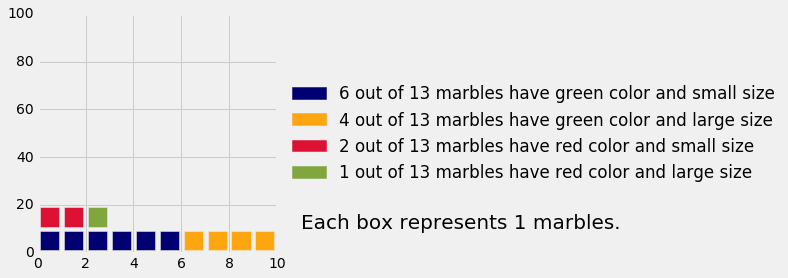

In [6]:
# Run this cell.
display_grouped_icon_array(marbles.groups(["color", "size"]), "marbles")

Note that the icon colors don't correspond to the colors of the marbles they represent.

You (the marble) should imagine that you are a random draw from these 13 icons.

**Question 2.2.** Make an icon array of the marbles, grouped **only by color**.

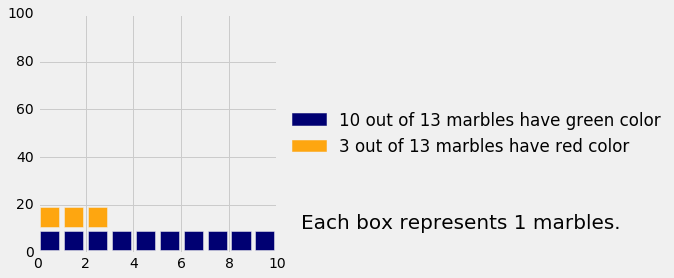

In [7]:
display_grouped_icon_array(marbles.group("color"), "marbles") #SOLUTION

This shows you how likely you are to be a green marble, *knowing nothing else about yourself*.  Remember, you're equally likely to be any of the marbles pictured.  So to compute the probability that you're a green marble, just divide the number of green marbles by the total number of marbles shown.

**Question 2.3.** What's the probability that you're a green marble?  Calculate this by hand by looking at your icon array.

In [8]:
probability_green = 10/13 #SOLUTION

In [9]:
_ = lab14.grade("q23")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



## 2.1. Conditional probability

Suppose you overhear Samantha saying that you're a large marble.  (Though marbles lack eyes, they possess rudimentary ears.)  Should this change the likelihood that you're green?  Let's find out.

Go back to the full icon array, displayed below for convenience.

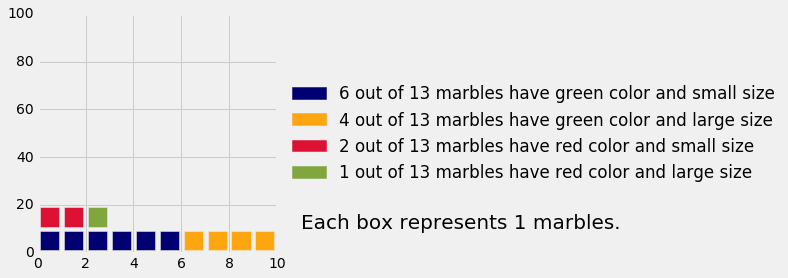

In [10]:
display_grouped_icon_array(marbles.groups(["color", "size"]), "marbles")

In question 2.3, we assumed you were equally likely to be any of the marbles, because we didn't know any better.  That's why we looked at all the marbles to compute the probability you were green.

But assuming (the statistician would say "conditioning on the fact that") you're a large marble, we can eliminate some of these possibilities.  In particular, you can't be a small green marble or a small red marble.

You're still equally likely to be any of the remaining marbles, because you don't know anything that says otherwise.  So here's an icon array of those remaining possibilities:

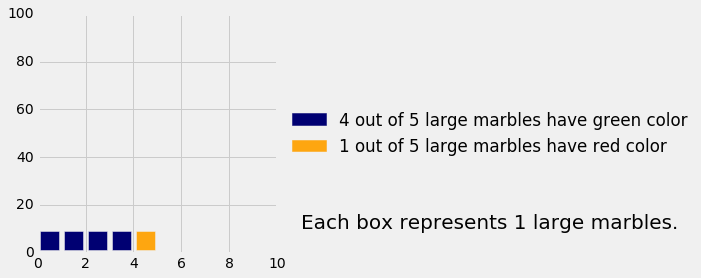

In [11]:
# Just run this cell.
display_grouped_icon_array(marbles.where("size", "large").group("color"), "large marbles")

**Question 2.1.1.** What's the probability you're a green marble, knowing that you're a large marble?  Calculate it by hand, using the icon array.

In [12]:
probability_green_given_large = 4/5 #SOLUTION

In [13]:
_ = lab14.grade("q211")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



You should have found that this is different from the probability that you're a green marble, which you computed earlier.  The distribution of colors among the large marbles is a little different from the distribution of colors among all the marbles.

**Question 2.1.2.** Suppose instead Samantha had said you're a green marble.  What's the probability you're large?  Make an icon array to help you compute this probability, then compute it.

*Hint:* Look at the code we wrote to generate an icon array for question 2.1.1.

*Hint 2:* Remember, this time you're equally likely to be any of the **green** marbles.

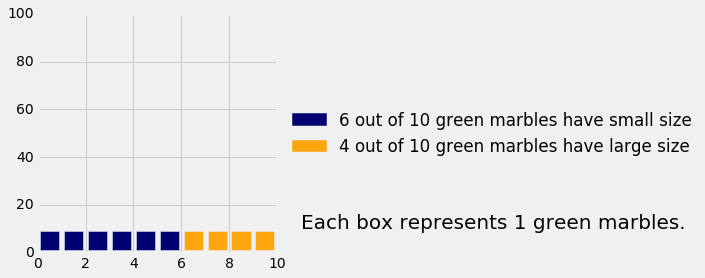

In [14]:
# Make an icon array to help you compute the answer.
display_grouped_icon_array(marbles.where("color", "green").group("size"), "green marbles") #SOLUTION

# Now compute the answer.
probability_large_given_green = 4/10 #SOLUTION

In [15]:
_ = lab14.grade("q212")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 2.1.3.** How could you answer the last two questions just by looking at the full icon array?  (You can run the cell below to see it again.)

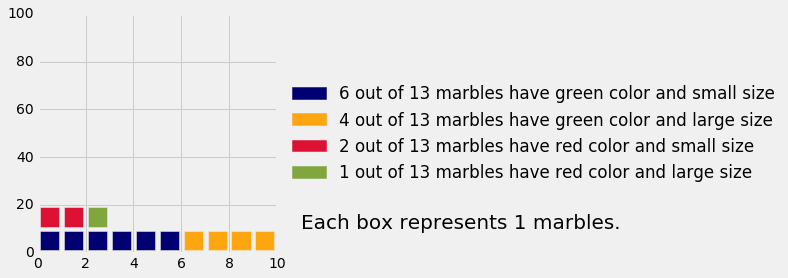

In [16]:
# Just run this cell.  The next cell is where you should write your answer.
display_grouped_icon_array(marbles.groups(["color", "size"]), "marbles")

*Write your answer here, replacing this text.*

# 3. Cancer screening
Now let's look at a much more realistic application.

### Background
Medical tests are an important but surprisingly controversial topic.  For years, women have been advised to get regular mammograms (tests for breast cancer).  Today, there is controversy over whether the tests are useful at all!

Part of the problem with such tests is that they are not perfectly reliable.  Someone without cancer can see a positive result on a test for cancer, and someone with cancer can receive a negative result.  ("Positive" means "pointing toward cancer," so in this context it's bad!)  Doctors and patients often deal poorly with the first case, called *false positives*.  For example, a patient may receive dangerous treatment like chemotherapy or radiation despite having no cancer or, as happens more frequently, having a cancer that would not have impacted her health.

Conditional probability is a good way to think about such situations.  For example, you can compute the chance that you have cancer, given the result of a test, by combining information from different probability distributions.  You'll see that the chance you have cancer can be far from 100% even if you have a positive test result from a test that is usually accurate.

## 3.1. Basic cancer statistics
Suppose that, in a representative group of 10,000 people who are tested for cancer ("representative" meaning that the frequencies of different things are the same as the frequencies in the whole population):
1. 100 have cancer.
2. Among those 100, 90 have positive results on a cancer test and 10 have negative results.  ("Negative" means "not pointing toward cancer.")
3. The other 9,900 don't have cancer.
4. Among these, 198 have positive results on a cancer test and the other 9,702 have negative results.  (So 198 see "false positive" results.)

Below we've generated a table with data from these 10,000 hypothetical people.

In [17]:
# Just run this cell.
people = Table(["cancer status", "test status", "count"]).with_rows([
        ["sick", "positive", 90],
        ["sick", "negative", 10],
        ["healthy", "positive", 198],
        ["healthy", "negative", 9702]
    ])
people

cancer status,test status,count
sick,positive,90
sick,negative,10
healthy,positive,198
healthy,negative,9702


One way to visualize this dataset is with a contingency table, which you've seen before.

**Question 3.1.1.** Create a contingency table that looks like this:

|cancer status|negative|positive|
|-|-|-|
|sick|||
|healthy||||

...with the **count** of each group filled in, according to what we've told you above.  The counts in the 4 boxes should sum to 10,000.

*Hint:* Use `pivot` with the `sum` function.

In [18]:
cancer = people.pivot("test status", "cancer status", "count", sum) #SOLUTION
cancer

cancer status,negative,positive
healthy,9702,198
sick,10,90


In [19]:
_ = lab14.grade("q311")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 3.1.2.** Display the `people` data in an icon array.  The name of the population members should be "people who've taken a cancer test".

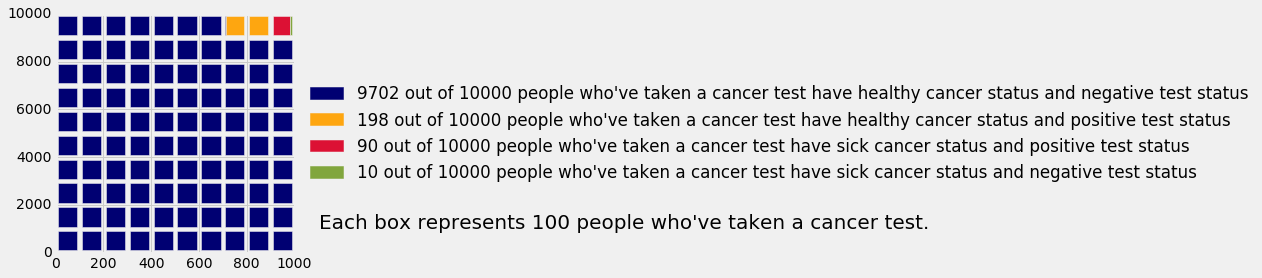

In [20]:
display_grouped_icon_array(people, "people who've taken a cancer test") #SOLUTION

Now let's think about how you can use this kind of information when you're tested for cancer.

Before you know any information about yourself, you could imagine yourself as a **uniform random sample** of one of the 10,000 people in this imaginary population of people who have been tested.

What's the chance that you have cancer, knowing nothing else about yourself?  It's $\frac{100}{10000}$, or 1%.  We can see that more directly with this icon array:

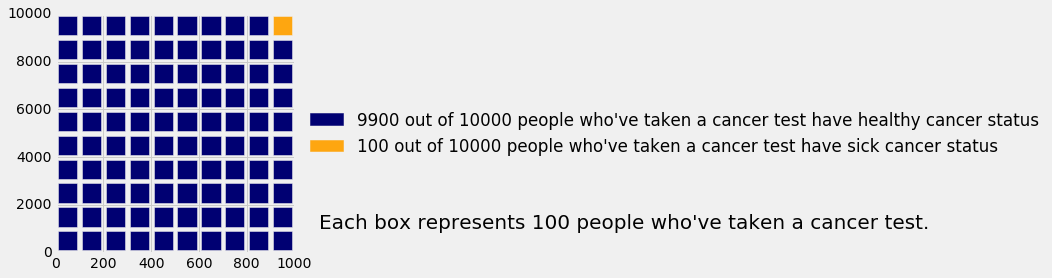

In [21]:
by_health = people.select([0, 2]).group(0, sum).relabeled(1, 'count')
display_grouped_icon_array(by_health, "people who've taken a cancer test")

**Question 3.1.3.** What's the chance that you have a positive test result, knowing nothing else about yourself?

*Hint:* Make an icon array.

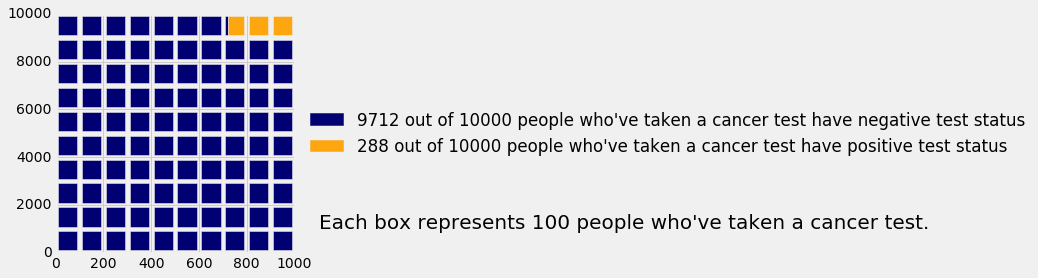

In [22]:
# We first made an icon array in the 2 lines below.
by_test = people.select([1, 2]).group(0, sum).relabeled(1, 'count') # SOLUTION
display_grouped_icon_array(by_test, "people who've taken a cancer test")

# Fill in the probabiliy of having a positive test result.
probability_positive_test = 288/10000 # SOLUTION

In [23]:
_ = lab14.grade("q313")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



## 3.2. Interpreting test results
Suppose you have a positive test result.  This means you can now narrow yourself down to being part of one of two groups:
1. The people with cancer who have a positive test result.
2. The people without cancer who have a positive test result.

Here's an icon array for those two groups:

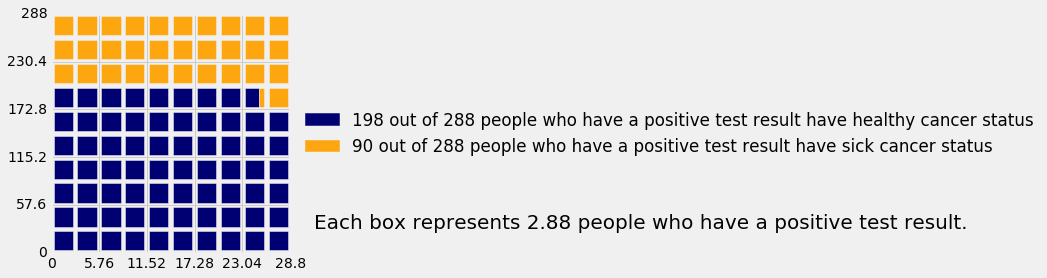

In [24]:
# Just run this cell.
display_grouped_icon_array(people.where("test status", "positive").drop(1), "people who have a positive test result")

The *conditional probability* that you have cancer *given* your positive test result is the chance that you're in the first group, assuming you're in one of these two groups.

**Question 3.2.1.** Eyeballing it, is the conditional probability that you have cancer given your positive test result closest to:
1. 9/10
2. 2/3
3. 1/2
4. 1/3
5. 1/100

In [25]:
# Set this to one of the numbers above.
rough_prob_sick_given_positive = 1/3 #SOLUTION

In [26]:
_ = lab14.grade("q321")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 3.2.2.** Now write code to calculate that probability exactly, using the original contingency table you wrote.

In [46]:
prob_sick_given_positive = cancer.where("cancer status", "sick").column("positive").item(0) / sum(cancer.column("positive")) # SOLUTION
prob_sick_given_positive


0.3125

In [28]:
_ = lab14.grade("q322")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 3.2.3.** Look at the full icon array again.  Using that, how would you compute (roughly) the conditional probability of cancer given a positive test?

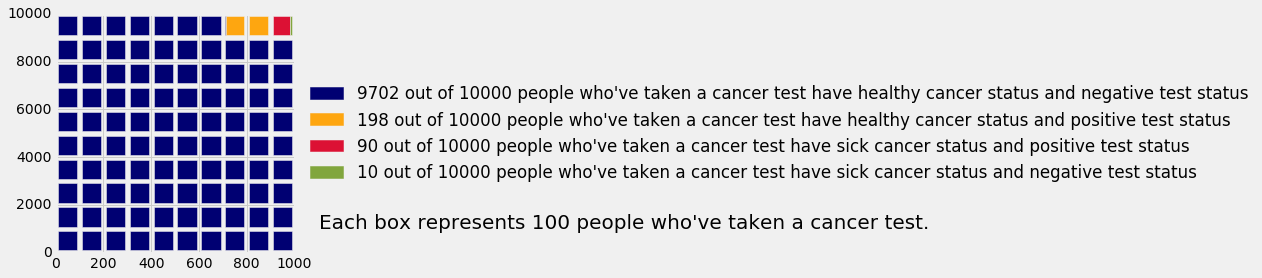

In [29]:
# The full icon array is given here for your convenience.
# Write your answer in the next cell.
display_grouped_icon_array(people, "people who've taken a cancer test")

*Write your answer here, replacing this text.*

**Question 3.2.4.** Is your answer to question 3.2.2 bigger than the overall proportion of people in the population who have cancer?  Does that make sense?

*Write your answer here, replacing this text.*

# 4. [Optional] The traditional, more confusing way to look at this
This section is **optional** but highly recommended.  It's good practice for working with probabilities.

Often, information about disease and test probabilities is given in a different format.  For example, people often summarize the information in your `cancer` using 3 numbers:

1. The overall probability of having cancer is **`X`**.  (This is called the *base rate* or *marginal probability* of the disease.)
2. Given that you have cancer, the probability of a positive test result is **`Y`**.  (This is called the *sensitivity* of the test.  Higher values of `Y` mean the test is more useful.)
3. Given that you don't have cancer, the probability of a positive test result is **`Z`**.  (This is called the *false positive rate* of the test.  Higher values of `Z` mean the test is less useful.)

Why is this format common?  Well, in reality somebody has to compute all these probabilities.  And these are the most natural to *compute*, especially from samples:

|Information|How to compute it|
|-|-|
|base rate `X`|Check how many people have cancer.|
|sensitivity `Y`|Give the test to a bunch of people with cancer and see how many are positive.|
|false positive rate `Z`|Give the test to a bunch of people without cancer and see how many are positive.||

But they're less convenient for the people using them to make decisions.  Let's see how to work with them.  First let's compute them.

You already saw that the base rate of cancer (which we'll call `X` for short) was .01 in the previous section.  `Y` and `Z` can be computed using the same method you used to compute the conditional probability of cancer given a positive test result.

**Question 4.1.** Compute `Y` and `Z` for the data in section 3.  You can use an icon array or compute them only with code.  You can run the tests to see the right answers.

In [30]:
# Hint: You may find these two tables useful:
has_cancer = cancer.where("cancer status", "sick")
no_cancer = cancer.where("cancer status", "healthy")

X = .01
Y = (has_cancer.column("positive").item(0) / 10000) / X #SOLUTION
Z = (no_cancer.column("positive").item(0) / 10000) / (1 - X) #SOLUTION

print('X:', X, ' Y:', Y, ' Z:', Z)

X: 0.01  Y: 0.8999999999999999  Z: 0.02


In [31]:
_ = lab14.grade("q41")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



You can see why this might be confusing.  From these numbers, it looks like the test is really accurate, so you'd expect to be very sure you have cancer if you have a positive test result!

Instead of answering questions directly from these numbers, it's easier (when you're first starting out) to use visual tools like contingency tables and icon arrays.  So let's see how to build a table like `cancer` from these 3 pieces of information.  We'll make them a little different so that the table ends up different.  So suppose that instead we're thinking about a rare genetic disease with the following characteristics:

* The base rate of the disease among people who take the test is .001.  (That is, 10 out of 10,000 people who take the test actually have the disease.)
* The probability of testing positive for the disease, given that you have the disease, is .5.
* The probability of testing positive for the disease, given that you **don't** have the disease, is .1.

**Question 4.2.** Make a table by hand called `disease_marginal`.  It should look like this:

|disease status|all|
|-|-|
|disease||
|no disease|||

Fill it in so that the proportion of people with the disease is .001 and so that the counts add up to 10,000.

In [32]:
total_people = 10000
base_rate = .001
sensitivity = .5
false_positive_rate = .1

disease_marginal = Table().with_columns([
        "disease status", ["disease", "no disease"],
        "all", [base_rate*total_people, (1-base_rate)*total_people] # SOLUTION
])
disease_marginal

disease status,all
disease,10
no disease,9990


In [33]:
_ = lab14.grade("q42")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



Now split up each category.  Among the people with the disease, how many test positive?  That's based on the sensitivity, so the answer is half of the 10 people with the disease, or 5.

**Question 4.3.** Splitting people up into the 4 categories in the same way, generate a contingency table called `disease` that looks like this:

|disease status|negative|positive|
|-|-|-|
|disease|||
|no disease||||

Again, the numbers in the 4 cells should sum to 10,000.

In [34]:
disease = Table().with_columns([
        "disease status", ["disease", "no disease"],
        "negative", [base_rate*(1-sensitivity)*total_people, (1-base_rate)*(1-false_positive_rate)*total_people], #SOLUTION
        "positive", [base_rate*sensitivity*total_people, (1-base_rate)*false_positive_rate*total_people] #SOLUTION
])
disease

disease status,negative,positive
disease,5,5
no disease,8991,999


In [35]:
_ = lab14.grade("q43")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



Now we can use `display_crosstab_icon_array` to look at the information.

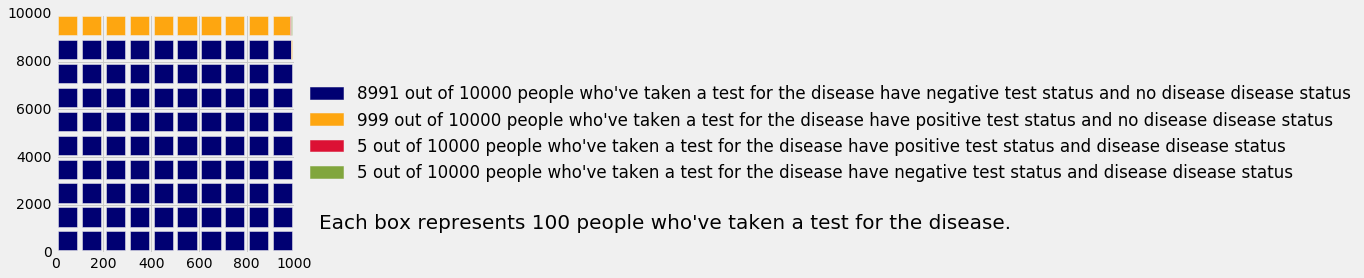

In [36]:
# Just run this cell.
display_crosstab_icon_array(disease, "test status", "people who've taken a test for the disease")

Notice you can barely see the people who are positive for the disease, because there are so few of them!  This is a problem with this kind of visualization.

Still, it does show you an important fact: **most people who test positive don't actually have the disease**.

Let's make that more precise.

**Question 4.4.** Compute the probability of having the disease, given that you have a positive test result.

In [37]:
prob_disease_given_positive = disease.column("positive").item(0) / sum(disease.column("positive"))
prob_disease_given_positive

0.0049800796812749003

In [38]:
_ = lab14.grade("q44")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 4.5.** Is this bigger than the base rate of the disease?  (The test would be pretty pointless if this weren't true!)

*Write your answer here, replacing this text.*

**Question 4.6.** Is it close to the sensitivity of the test, which is .5?

*Write your answer here, replacing this text.*

**Question 4.7.** Is it big enough that you should worry a lot?

*Write your answer here, replacing this text.*

In [39]:
# For your convenience, you can run this cell to run all the tests at once!
import os
print("Running all tests...")
_ = [lab14.grade(q[:-3]) for q in os.listdir("tests") if q.startswith('q')]
print("Finished running all tests.")

Running all tests...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running t

In [40]:
# Run this cell to submit your work *after* you have passed all of the test cells.
# It's ok to run this cell multiple times. Only your final submission will be scored.

!TZ=America/Los_Angeles ipython nbconvert --output=".lab14_$(date +%m%d_%H%M)_submission.html" lab14.ipynb && echo "Submitted successfully."

[NbConvertApp] Converting notebook lab14.ipynb to html
[NbConvertApp] Writing 710491 bytes to .lab14_0507_0144_submission.html
Submitted successfully.
